In [1]:
import sys
sys.path.append('../')
# Set cuda device
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import torch
import numpy as np
import gzip
import json
from detectron2_extensions.config import get_cfg as get_detectron_cfg
from detectron2.config import CfgNode
from typing import Sequence, List, Dict, Any
import omegaconf
from vq2d.data.vq2d_inference_dataloader import (
    VQ2DInferenceDataset, FrameDataset,
    VQ2DInferenceDataset2, FrameDataset2,
)
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
import cv2
import time
from tqdm.auto import tqdm
from multiprocessing import Pool
import detectron2.data.transforms as T
from detectron2.engine import DefaultPredictor
from decord import VideoReader
import decord
decord.bridge.set_bridge('native')
# decord.bridge.set_bridge("torch")
from decord import gpu, cpu
import pims
import matplotlib.pyplot as plt


In [2]:
detectron_cfg = get_detectron_cfg()
detectron_cfg.merge_from_file("/scratch/shared/beegfs/prannay/ego4d_data/ckpt/perframe_run/config.yaml")


In [3]:
detectron_cfg.MODEL.META_ARCHITECTURE

'SiameseRCNN'

In [4]:
# detectron_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0
# detectron_cfg.MODEL.WEIGHTS = "/work/prannay/ego4d/ckpt/model_0064999.pth"
# detectron_cfg.MODEL.DEVICE = f"cuda:0"
# # detectron_cfg.INPUT.FORMAT = "RGB"

In [5]:
with open("../data/val_annot.json", "r") as fp:
    annot = json.load(fp)

In [6]:
# pims_dataset = VQ2DInferenceDataset(detectron_cfg, annot, "/scratch/shared/beegfs/prannay/ego4d_data/vq2d_clips_val_libx265")

In [7]:
decord_dataset = VQ2DInferenceDataset2(detectron_cfg, annot, "/scratch/shared/beegfs/prannay/ego4d_data/vq2d_clips_val")

In [8]:
# output_pims = pims_dataset[0]
output_decord = decord_dataset[2]

In [9]:
output_decord['dataset_uid']

'val_0000000002'

In [10]:
detectron_cfg.INPUT.FORMAT

'BGR'

In [11]:
output_decord['reference']

tensor([[[125., 125., 125.,  ..., 125., 125., 125.],
         [125., 125., 125.,  ..., 125., 125., 125.],
         [125., 125., 125.,  ..., 125., 125., 125.],
         ...,
         [125., 125., 125.,  ..., 125., 125., 125.],
         [125., 125., 125.,  ..., 125., 125., 125.],
         [125., 125., 125.,  ..., 125., 125., 125.]],

        [[125., 125., 125.,  ..., 125., 125., 125.],
         [125., 125., 125.,  ..., 125., 125., 125.],
         [125., 125., 125.,  ..., 125., 125., 125.],
         ...,
         [125., 125., 125.,  ..., 125., 125., 125.],
         [125., 125., 125.,  ..., 125., 125., 125.],
         [125., 125., 125.,  ..., 125., 125., 125.]],

        [[125., 125., 125.,  ..., 125., 125., 125.],
         [125., 125., 125.,  ..., 125., 125., 125.],
         [125., 125., 125.,  ..., 125., 125., 125.],
         ...,
         [125., 125., 125.,  ..., 125., 125., 125.],
         [125., 125., 125.,  ..., 125., 125., 125.],
         [125., 125., 125.,  ..., 125., 125., 125.]]]

In [12]:
# frames_pims_dataset = FrameDataset(
#     output_pims["clip_frames"],
#     detectron_cfg,
#     output_pims["oheight"],
#     output_pims["owidth"],
# )

In [13]:
frames_decord_dataset = FrameDataset2(
    output_decord["clip_frames"],
    output_decord["search_window"][-1],
    detectron_cfg,
    output_decord["oheight"],
    output_decord["owidth"],
)

In [14]:
len(frames_decord_dataset)

1787

In [14]:
trial = [frames_decord_dataset[x] for x in [1732, 1733, 1734]]

In [15]:
# len(frames_decord_dataset) + trial[1][1]

In [23]:
trial[0][0].mean(dim=(1, 2))

tensor([110.8854, 102.9159, 103.7919])

In [20]:
trial[1][0].permute(1, 2, 0).numpy().min()

0.0

In [21]:
print(trial[1][0].permute(1, 2, 0).float().mean())
print(trial[1][0].permute(1, 2, 0).float().std())

tensor(103.8696)
tensor(57.5751)


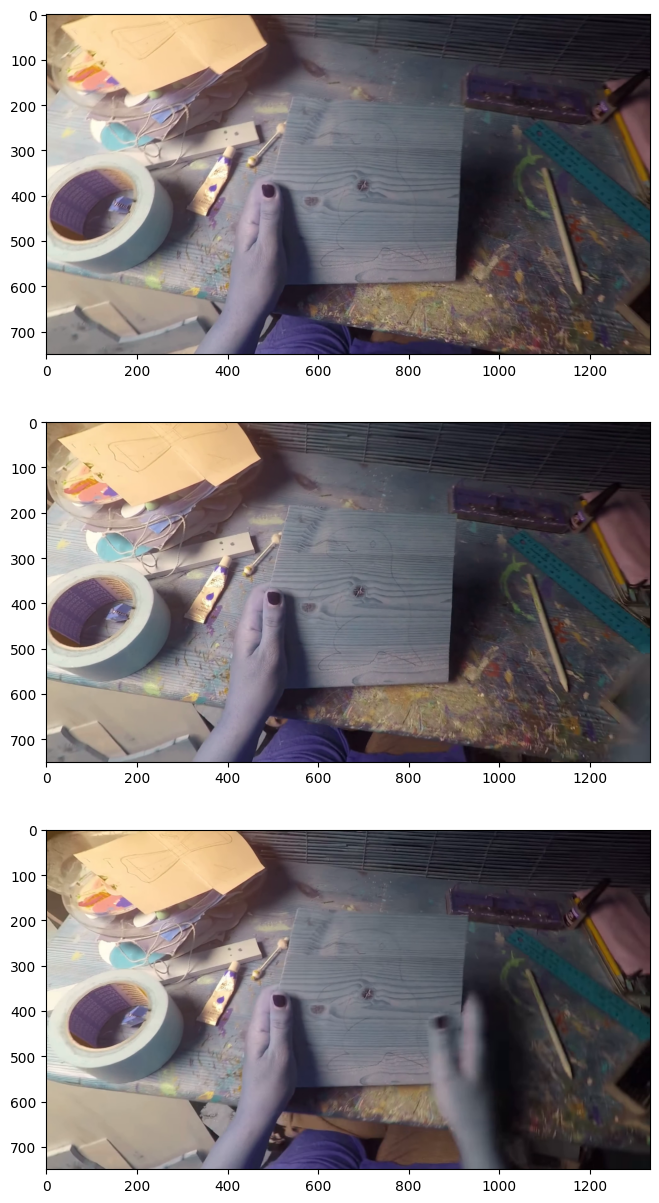

In [22]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
ax[0].imshow(trial[0][0].byte().permute(1, 2, 0).numpy())
ax[1].imshow(trial[1][0].byte().permute(1, 2, 0).numpy())
ax[2].imshow(trial[2][0].byte().permute(1, 2, 0).numpy())

# ax[1].imshow(output_decord['reference'].byte().permute(1, 2, 0).numpy())
plt.show()

In [12]:
frames_pims = frames_pims_dataset[0]
frames_decord = frames_decord_dataset[0]

In [13]:
for f in frames_pims:
    if isinstance(f, torch.Tensor):
        print(f.shape)
    else:
        print(f)

torch.Size([3, 750, 1333])
0
1080
1920


In [14]:
for f in frames_decord:
    if isinstance(f, torch.Tensor):
        print(f.shape)
    else:
        print(f)

torch.Size([3, 750, 1333])
0
1080
1920


In [15]:
## reverse pims frame channel and compare 

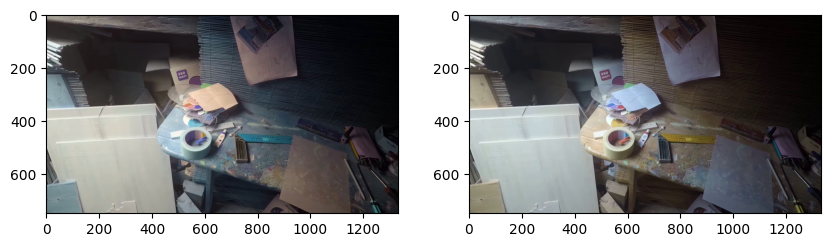

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(frames_pims[0].permute(1, 2, 0).numpy().astype(int))
ax[1].imshow(frames_decord[0].permute(1, 2, 0).numpy().astype(int))
plt.show()

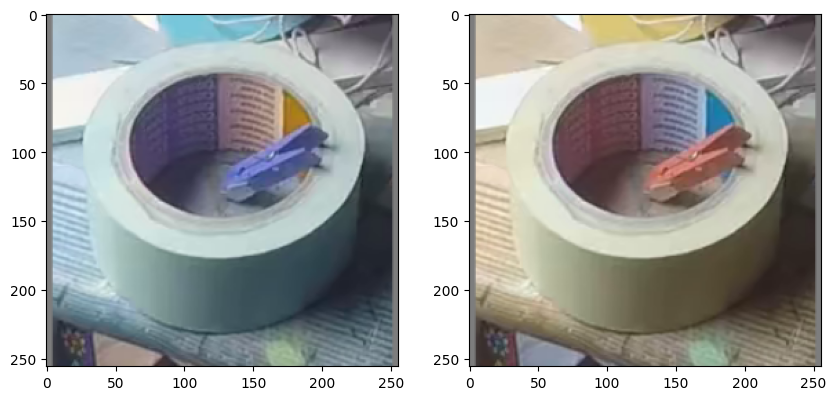

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(output_pims['reference'].permute(1, 2, 0).numpy().astype(int))
ax[1].imshow(output_decord['reference'].permute(1, 2, 0).numpy().astype(int))
plt.show()

In [3]:
annotation = annot[0]
query_frame = annotation["query_frame"]
visual_crop = annotation["visual_crop"]
vcfno = visual_crop['frame_number']
video_path = "/scratch/shared/beegfs/prannay/ego4d_data/vq2d_clips_val/" + annotation['clip_uid'] + ".mp4"

In [4]:
decord_video = VideoReader(video_path)

In [5]:
type(decord_video[:-1].asnumpy())

numpy.ndarray

In [13]:
fin_frame = max(query_frame, vcfno)
batch_size = 16
num_batches = (fin_frame // batch_size) + (1 if fin_frame % batch_size != 0 else 0)
shapes_decord = []
for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, fin_frame + 1)
    clip_frames_decord = decord_video.get_batch(range(start_idx, end_idx)).asnumpy()
    for frame in clip_frames_decord:
        shapes_decord.append(frame.shape)
# shapes_decord = []
# clip_frames_decord = decord_video[:max(query_frame, vcfno) + 1]
# for frame in clip_frames_decord.asnumpy():
#     shapes_decord.append(frame.shape)


In [15]:
pims_video = pims.Video(video_path)

In [16]:
shapes_pims = []
clip_frames_pims = pims_video[:max(query_frame, vcfno) + 1]
batch_size = 16
fin_frame = len(clip_frames_pims)
# print(fin_frame)
num_batches = (fin_frame // batch_size) + (1 if fin_frame % batch_size != 0 else 0)
shapes_pims = []
for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, fin_frame + 1)
    clip_frames_pims = pims_video[start_idx:end_idx]
    for frame in clip_frames_pims:
        shapes_pims.append(frame.shape)

In [18]:
type(clip_frames_pims)

slicerator.Slicerator

In [8]:
predictor = DefaultPredictor(detectron_cfg)

In [7]:
dataset = VQ2DInferenceDataset(
    detectron_cfg,
    annot,
    "/scratch/shared/beegfs/prannay/ego4d_data/vq2d_clips_val_libx265"
)

In [12]:
out_dict = dataset[1]
print(out_dict.keys())
frames, search_window, reference, query_frame, clip_uid, oheight, owidth, dataset_uid = (
    out_dict["clip_frames"],
    out_dict["search_window"],
    out_dict["reference"],
    out_dict["query_frame"],
    out_dict["clip_uid"],
    out_dict["oheight"],
    out_dict["owidth"],
    out_dict["dataset_uid"]
)

dict_keys(['clip_frames', 'search_window', 'reference', 'query_frame', 'clip_uid', 'oheight', 'owidth', 'dataset_uid', 'response_track', 'visual_crop'])


In [15]:
print(len(frames), search_window[-1])

81 79


: 

In [61]:
def process_batch(batch):
    frames = torch.stack([x[0] for x in batch])
    fno = torch.tensor([x[1] for x in batch], dtype=torch.long)
    heights = torch.tensor([x[2] for x in batch], dtype=torch.long)
    widths = torch.tensor([x[3] for x in batch], dtype=torch.long)
    return frames, fno, heights, widths

In [37]:
data_loader = DataLoader(
    FrameDataset(frames, detectron_cfg, oheight, owidth), batch_size=12, num_workers=0, collate_fn=process_batch)
# print(frame_dataset[1043][1])
shapes_old = []
t = time.time()
for data in data_loader:
    shapes_old.append(data[0].shape)
print(time.time() - t)
# data_iter = iter(data_loader)
# frames, fno, heights, widths = next(data_iter)

105.42109107971191


In [62]:
print(frames[0])

[[[137 147 153]
  [137 147 153]
  [137 147 153]
  ...
  [  4   2   0]
  [  4   2   0]
  [  4   2   0]]

 [[141 151 157]
  [141 151 157]
  [141 151 157]
  ...
  [  3   1   0]
  [  3   1   0]
  [  3   1   0]]

 [[145 155 161]
  [145 155 161]
  [145 155 161]
  ...
  [  3   1   0]
  [  3   1   0]
  [  3   1   0]]

 ...

 [[115 114 103]
  [115 114 103]
  [115 114 103]
  ...
  [ 34  27  27]
  [ 35  28  28]
  [ 37  30  30]]

 [[115 114 103]
  [115 114 103]
  [115 114 103]
  ...
  [ 27  20  20]
  [ 24  17  17]
  [ 23  16  16]]

 [[115 114 103]
  [115 114 103]
  [115 114 103]
  ...
  [ 21  14  14]
  [ 15   8   8]
  [ 12   5   5]]]


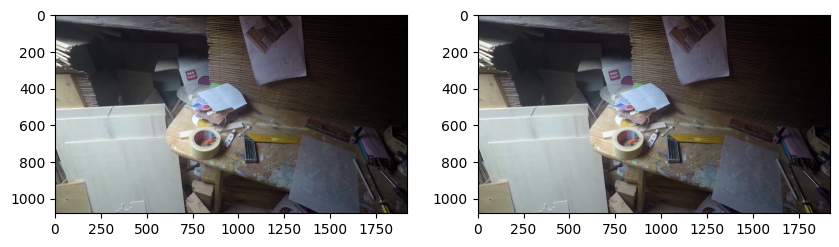

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(pims_video[0])
ax[1].imshow(decord_video[0].asnumpy())
plt.show()

In [45]:
class FrameDataset2(Dataset):
    def __init__(
            self,
            frames,
            fin_frame: int,
            cfg: CfgNode,
            oheight: int,
            owidth: int,
            downscale_height: int,
    ):
        self.frames = frames
        self.fin_frame = fin_frame
        self.cfg = cfg
        self.oheight = oheight
        self.owidth = owidth
        self.downscale_height = downscale_height

        self.aug = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )

    def __len__(self):
        return self.fin_frame

    def __getitem__(self, idx):
        image = self.frames[idx].asnumpy()
        fno = idx
        if image.shape[:2] != (self.oheight, self.owidth):
            image = cv2.resize(image, (self.owidth, self.oheight))
        # reverse colour channels
        # if self.cfg.INPUT.FORMAT == "RGB":
        #     image = image[:, :, ::-1]
        height, width = image.shape[:2]
        image = self.aug.get_transform(image).apply_image(image)
        image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
        # # Scale-down image to reduce memory consumption
        # image_scale = float(self.downscale_height) / image.shape[0]
        # image = cv2.resize(image, None, fx=image_scale, fy=image_scale)
        # image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
        return image, fno, height, width

In [48]:
data_loader = DataLoader(
    FrameDataset2(decord_video, max(query_frame, vcfno), detectron_cfg, oheight, owidth, 800), batch_size=12, num_workers=0, collate_fn=process_batch)
# print(frame_dataset[1043][1])
shapes_new = []
t = time.time()
for data in data_loader:
    shapes_new.append(data[0].shape)
print(time.time() - t)

ERROR: Unexpected segmentation fault encountered in worker.
 ERROR: Unexpected segmentation fault encountered in worker.
 ERROR: Unexpected segmentation fault encountered in worker.
 ERROR: Unexpected segmentation fault encountered in worker.
 

RuntimeError: DataLoader worker (pid(s) 137600) exited unexpectedly

In [16]:
predictions = predictor.model(
    [
        {"image": frames[0],
         "height": heights[0].item(),
         "width": widths[0].item(),
         "reference": reference,
         "title": "title"}
        ]
, False)

In [17]:
predictions[0]["instances"].scores.tolist()

[0.9901374578475952,
 0.0023486632853746414,
 0.0010822296608239412,
 0.0008383055683225393,
 0.0008234327542595565,
 0.0006142505444586277,
 0.0006121201440691948,
 0.0005338958580978215,
 0.00040693895425647497,
 0.00040651438757777214]

In [18]:
predictions[0]['instances'].pred_boxes.tensor

tensor([[ 723.0348,  608.1287,  912.4764,  793.6649],
        [1855.3313,  774.2768, 1920.0000,  949.9074],
        [   0.0000,  301.3317,  196.9473,  520.3307],
        [1857.0327,  744.0094, 1919.0206,  877.2192],
        [ 940.0711,    0.0000, 1390.2483,  527.2693],
        [   0.0000,  900.2159,  201.6238, 1080.0000],
        [ 711.0720,  341.6759,  847.7339,  549.3049],
        [1074.5642,   79.7594, 1379.3688,  391.0638],
        [1822.7517,  743.9793, 1916.4276,  983.3478],
        [1175.8225,  945.1943, 1394.7375, 1080.0000]], device='cuda:0')

In [15]:
print(
    frames[0, 0].mean(),
    frames[0, 0].std(),
    frames[0, 1].mean(),
    frames[0, 1].std(),
    frames[0, 2].mean(),
    frames[0, 2].std(),
    frames.size(),
)

tensor(85.1013) tensor(67.7376) tensor(84.9214) tensor(67.6861) tensor(86.3738) tensor(63.2145) torch.Size([12, 3, 750, 1333])


In [14]:
print(frames.shape)
print(fno)
print(heights)
print(widths)

torch.Size([12, 3, 750, 1333])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
tensor([1080, 1080, 1080, 1080, 1080, 1080, 1080, 1080, 1080, 1080, 1080, 1080])
tensor([1920, 1920, 1920, 1920, 1920, 1920, 1920, 1920, 1920, 1920, 1920, 1920])


In [10]:
t = time.time()
data_loader = DataLoader(
    FrameDataset(frames, detectron_cfg, oheight, owidth, downscale_height=700), batch_size=12, num_workers=0, collate_fn=process_batch)
for i in tqdm(data_loader):
    assert isinstance(i, tuple)
print(time.time() - t)

  0%|          | 0/120 [00:00<?, ?it/s]

37.4463906288147


In [18]:
reference.std()

tensor(58.4427)

In [14]:
i[0].shape

torch.Size([6, 3, 750, 1333])

In [45]:
i[0].shape

(6, 700, 1244, 3)

In [9]:
print(j.frame_no)
print(j.metadata)
print(j)

NameError: name 'j' is not defined

In [26]:
isinstance(j, np.ndarray)

True